This notebook uses a convulational neural network to output the input image.
The purpose is mostly so that I can better understand CNNs in general, 
consequently, this "algorithm" needs a lot of work.

For reference, this code works with Julia v1.4, Flux v0.10.3, and Images v0.22.0. Other versions have not been tested.

In [1]:
using Flux
using Images
using Plots

 - Do the image handling stuff to prepare the data for the CNN

In [2]:
image_in = load("../style_images/katsushika-hokusai_the-great-wave-off-kanagawa.jpg");  # Load the image 
imgview = Float32.(channelview(image_in));  # Create a view of the image and convert to Float32
imgWHC = permutedims(imgview, (3, 2, 1)); # Chane Images CHW order to Flux WHC order

In [3]:
img_data = Array{Float32}(undef, (size(imgWHC)[1:2]..., 3, 1));  # Create tensor
img_data[:, :, :, 1] = imgWHC;  # Stick image where it belongs

- Define helper functions that will ensure that the input image and output images are the same size

In [4]:
"""
nstrides1d(l, k, p, s)

nstrides1d is a function to calculate the number of kernel strides that fit in a given
length. This equals the size of a dimension after a convolution.
"""
nstrides1d(l, k, p, s) = ((l - k + p) / s + 1)


"""
nstrides2d(l, k, p, s)

nstrides2d is a convenience function that accepts tuple inputs in the manner expected for
the pad1d and pad2d functions and outpus 2-element tuple.
"""
nstrides2d(l, k, p, s) = (nstrides1d(l[1], k[1], p[1] + p[2], s[1]),
                         nstrides1d(l[2], k[2], p[3] + p[4], s[2]))


"""
pad1d(l, k, s)

Calculate the amount of padding needed to fit an integer number of kernel strides
across a given length. While pad_1d works for 2-D inputs, it is suggested to use
the helper function pad2d.

Inputs:
-------
l - length
k - kernel size
s - stride

Output:
----
A 2-element tuple with the number of elements needed to pad each side of a 1-D length.
"""
function pad1d(l, k, s)
    n = ceil((l - k)/s + 1)  # Number of whole kernels needed to cross l
    pad_tot = s*(n - 1) + k - l  # Padding needed to get to n kernels
    # If padding still does not give an inter number of kernel strides
    # Then print an error
    if ((l - k + pad_tot) / s + 1) % 1 != 0
        @error "Could not pad array properly"
    end
    # Try to evenly space padding between sides
    # left, right, top, and bottom sides.
    # The following pads bottom/right sides first
    p1 = pad_tot ÷ 2
    p2 = pad_tot - p1

    return convert.(Int, (p1, p2))
end

"""
pad2d(l, k, s)

Convience function for pad_1d. This function splats the output into a single,
N-element tuple rather than using pad_1d.(x, y, z), which outputs a tuple of tuples

Inputs:
-------
l - length
k - kernel size
s - stride

Output:
----
A 4-element tuple with the number of elements needed to pad each side of a 2-D matrix.
"""
pad2d(l, k, s) = (pad1d(l[1], k[1], s[1])...,  pad1d(l[2], k[2], s[2])...)


pad2d

 - Create the basic 3-layer "recoder" (encoder/decoder)

In [5]:
k = (3, 3);  # kernel size
s = (2, 2);  # stride size
d = (1, 1);  # dilation size

# Size and padding for the first layer
size1 = size(img_data)[1:2];
epad1 = pad2d(size1, k, s);
# Size and padding for the second layer
size2 = nstrides2d(size1, k, epad1, s);
epad2 = pad2d(size2, k, s);
# Size and padding for the third layer
size3 = nstrides2d(size2, k, epad2, s);
epad3 = pad2d(size3, k, s);

recode = Chain(# Encoder section
               Conv(k, 3=>32, relu, pad=epad1, stride=s, dilation=d),
               Conv(k, 32=>64, relu, pad=epad2, stride=s, dilation=d),
               BatchNorm(64),
               Conv(k, 64=>128, relu, pad=epad3, stride=s, dilation=d),
               # Decoder section
               ConvTranspose(k, 128=>64,relu, pad=epad3, stride=s, dilation=d),
               BatchNorm(64),
               ConvTranspose(k, 64=>32, relu, pad=epad2, stride=s, dilation=d),
               ConvTranspose(k, 32=>3, relu, pad=epad1, stride=s, dilation=d)
               );

 - Set up the variables for training

In [6]:
opt = Flux.ADAM()  # Standard optimizer
recode_loss(x) = Flux.mse(recode(x), x)  # Compares input image to its CNN version


recode_loss (generic function with 1 method)

 - Do the training

In [7]:
losses = []
nepochs = 1000
for i=1:nepochs
    #println("Training loop $i of $nepochs")
    Flux.train!(recode_loss, params(recode), [img_data], opt)
    push!(losses, recode_loss(img_data))
    #println("Total loss = $(losses[end])");
end

 - See how the loss performed

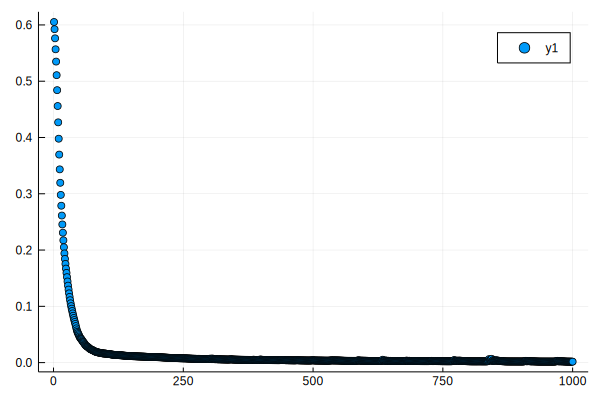

In [8]:
p = scatter(1:length(losses), losses)  # Make loss plot
display(p)  # Display the loss

 - Put the tensor back into RGB format

In [9]:
im_recoded = recode(img_data);  # Create the output tensor
outsize = size(im_recoded)[1:2];  # Get the final image dimension
output_features = reshape(im_recoded, (outsize..., 3));  # Remove the 4th dimension
output_perm = permutedims(output_features, (3, 2, 1)); # Flux WHC order to Images CHW orderr
image_out = colorview(RGB, output_perm); # Converts to an RGB image

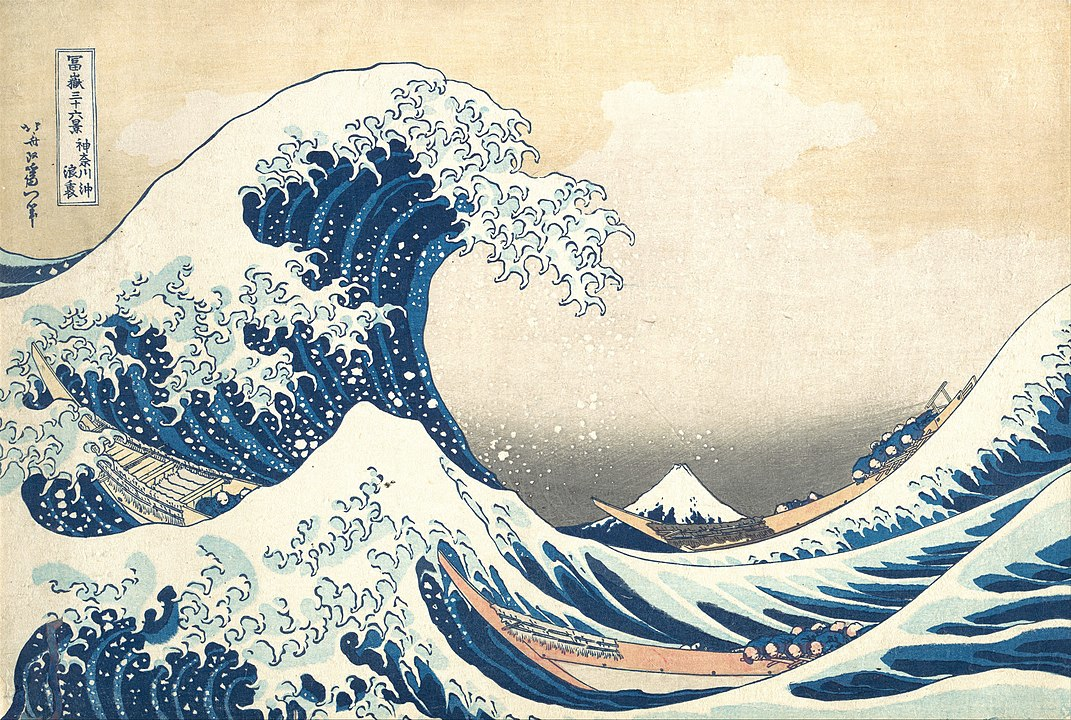

In [10]:
# The Great Wave off Kanagawa
image_in

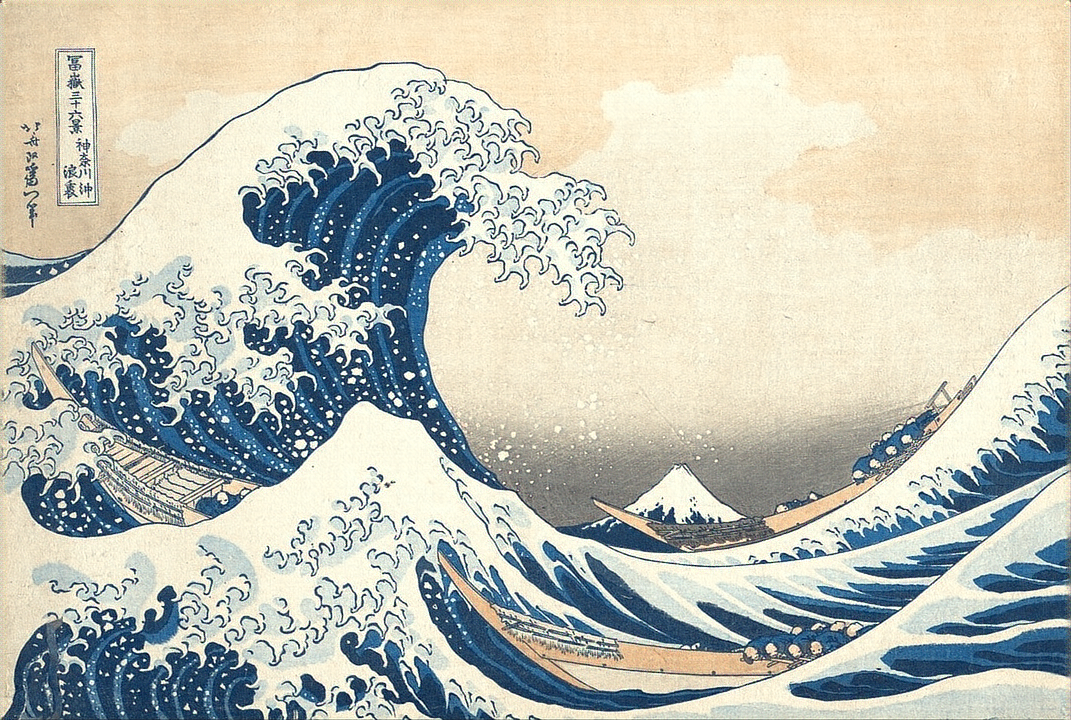

In [11]:
# The Not-so-Great Wave off Kanagawa
image_out

Notes:
 - Edge effects are noticeable
 - Image has pixelation
 - Colors aren't quite right

TODO: (in order)
 - Test more features and more layers